<a href="https://colab.research.google.com/github/deepakprasad181/DBMS/blob/main/Chatbot_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
data=pd.read_json('/content/Intents.json')
data.head()

,intents
0,"{'intent': 'Greeting', 'text': ['Hi', 'Hi ther..."
1,"{'intent': 'GreetingResponse', 'text': ['My us..."
2,"{'intent': 'CourtesyGreeting', 'text': ['How a..."
3,"{'intent': 'CourtesyGreetingResponse', 'text':..."
4,"{'intent': 'CurrentHumanQuery', 'text': ['What..."


In [9]:
def processing_json_dataset(data):
    tags = []
    inputs = []
    responses={}
    for intent in data['intents']:
        responses[intent['intent']]=intent['responses']
        for lines in intent['text']:
            inputs.append(lines)
            tags.append(intent['intent'])
    return [tags, inputs, responses]

In [10]:
[tags, inputs, responses] = processing_json_dataset(data)


In [11]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [12]:
dataset.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [13]:
dataset = dataset.sample(frac=1)
dataset.head()

,inputs,tags
76,Be quiet,Shutup
93,"Thank you, bye",CourtesyGoodBye
138,Can you prove you have a conscious,SelfAware
56,Time,TimeQuery
39,What can I call you?,NameQuery


In [14]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
dataset.head()

,inputs,tags
76,"[b, e, , q, u, i, e, t]",Shutup
93,"[t, h, a, n, k, , y, o, u, , b, y, e]",CourtesyGoodBye
138,"[c, a, n, , y, o, u, , p, r, o, v, e, , y, ...",SelfAware
56,"[t, i, m, e]",TimeQuery
39,"[w, h, a, t, , c, a, n, , i, , c, a, l, l, ...",NameQuery


In [15]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))
dataset.head()

,inputs,tags
76,be quiet,Shutup
93,thank you bye,CourtesyGoodBye
138,can you prove you have a conscious,SelfAware
56,time,TimeQuery
39,what can i call you,NameQuery


In [16]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [17]:
input_shape = features.shape[1]
print(input_shape)

9


In [18]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  117
output length:  22


In [19]:
tokenizer.word_index


{'you': 1,
 'me': 2,
 'is': 3,
 'are': 4,
 'i': 5,
 'what': 6,
 'the': 7,
 'can': 8,
 'do': 9,
 'thanks': 10,
 'name': 11,
 'am': 12,
 'please': 13,
 'your': 14,
 'a': 15,
 'tell': 16,
 'pod': 17,
 'bay': 18,
 'door': 19,
 'adam': 20,
 'open': 21,
 'bella': 22,
 'prove': 23,
 'time': 24,
 'real': 25,
 'not': 26,
 'to': 27,
 'gossip': 28,
 'how': 29,
 'it': 30,
 'why': 31,
 'my': 32,
 'talking': 33,
 'call': 34,
 'know': 35,
 'see': 36,
 'good': 37,
 'thank': 38,
 'bye': 39,
 'who': 40,
 'hello': 41,
 'goodbye': 42,
 'wasnt': 43,
 'great': 44,
 'this': 45,
 'very': 46,
 'user': 47,
 'quiet': 48,
 'have': 49,
 'conscious': 50,
 'some': 51,
 'doing': 52,
 'well': 53,
 'there': 54,
 'for': 55,
 'ok': 56,
 'any': 57,
 'will': 58,
 'hi': 59,
 'clever': 60,
 'girl': 61,
 'joke': 62,
 'be': 63,
 'think': 64,
 'hope': 65,
 'hya': 66,
 'saying': 67,
 'fuck': 68,
 'anyone': 69,
 'in': 70,
 'camera': 71,
 'genious': 72,
 'whats': 73,
 'self': 74,
 'aware': 75,
 'selfaware': 76,
 'up': 77,
 'hola':

In [20]:
model = Sequential()
model.add(Input(shape=(features.shape[1])))
model.add(Embedding(vocabulary + 1,100))
model.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001)))
model.add(Dropout(0.3))
model.add(LSTM(32, dropout=0.3,return_sequences=True))
model.add(LSTM(16, dropout=0.3,return_sequences=False))
model.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001)))
model.add(Dropout(0.6))
model.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [21]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-11-05 15:31:07--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-05 15:31:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-11-05 15:33:46 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [22]:
model.layers


In [23]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [24]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [26]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [27]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


In [28]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [29]:
history_training = model.fit(features,labels,epochs=1000, batch_size=64, callbacks=[ earlyStopping])


Epoch 1/1000
3/3 [==============================] - 6s 26ms/step - loss: 3.0935 - accuracy: 0.1049
Epoch 2/1000
3/3 [==============================] - 0s 12ms/step - loss: 3.0879 - accuracy: 0.1399
Epoch 3/1000
3/3 [==============================] - 0s 12ms/step - loss: 3.0833 - accuracy: 0.0559
Epoch 4/1000
3/3 [==============================] - 0s 11ms/step - loss: 3.0860 - accuracy: 0.0629
Epoch 5/1000
3/3 [==============================] - 0s 12ms/step - loss: 3.0791 - accuracy: 0.0350
Epoch 6/1000
3/3 [==============================] - 0s 12ms/step - loss: 3.0778 - accuracy: 0.0210
Epoch 7/1000
3/3 [==============================] - 0s 13ms/step - loss: 3.0718 - accuracy: 0.0350
Epoch 8/1000
3/3 [==============================] - 0s 14ms/step - loss: 3.0707 - accuracy: 0.0839
Epoch 9/1000
3/3 [==============================] - 0s 15ms/step - loss: 3.0651 - accuracy: 0.0769
Epoch 10/1000
3/3 [==============================] - 0s 14ms/step - loss: 3.0588 - accuracy: 0.0699
Epoch 11/

In [30]:
history_training = model.fit(features,labels,epochs=1000, batch_size=64, callbacks=[ earlyStopping])


Epoch 1/1000
3/3 [==============================] - 0s 42ms/step - loss: 0.2243 - accuracy: 0.9510
Epoch 2/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.1454 - accuracy: 0.9580
Epoch 3/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.1497 - accuracy: 0.9790
Epoch 4/1000
3/3 [==============================] - 0s 39ms/step - loss: 0.1773 - accuracy: 0.9650
Epoch 5/1000
3/3 [==============================] - 0s 25ms/step - loss: 0.2025 - accuracy: 0.9301
Epoch 6/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.1956 - accuracy: 0.9510
Epoch 7/1000
3/3 [==============================] - 0s 28ms/step - loss: 0.1388 - accuracy: 0.9510
Epoch 8/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.1748 - accuracy: 0.9580
Epoch 9/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.1276 - accuracy: 0.9790
Epoch 10/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.1558 - accuracy: 0.9580
Epoch 11/

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl
def draw_plot(data, type_data):
    mpl.style.use('seaborn')
    plt.figure(figsize = (25, 5))
    plt.plot(data,'darkorange', label='Train')
    plt.xlabel('Epoch')
    plt.ylabel(type_data)
    plt.legend()

<ipython-input-31-51922354e33a>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


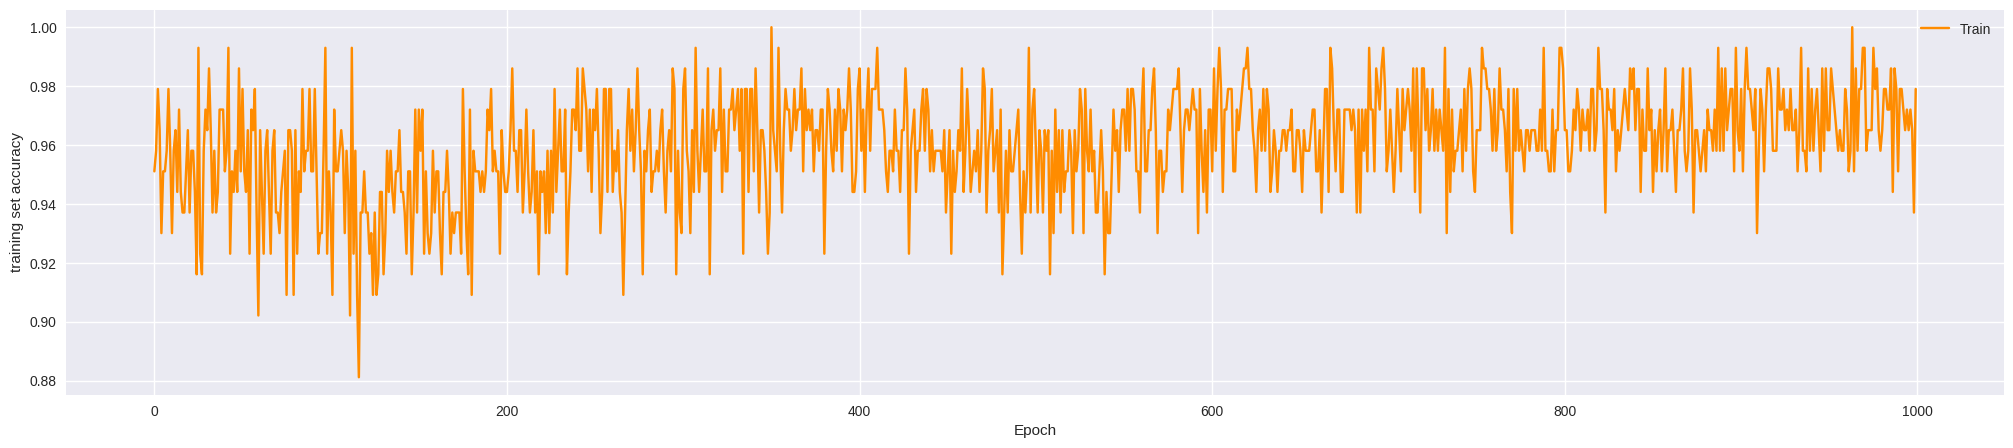

In [32]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )


In [33]:
import random
def generate_answer(query):
    texts = []
    pred_input = query
    pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
    pred_input = ''.join(pred_input)
    texts.append(pred_input)
    pred_input = tokenizer.texts_to_sequences(texts)
    pred_input = np.array(pred_input).reshape(-1)
    pred_input = pad_sequences([pred_input],input_shape)
    output = model.predict(pred_input)
    output = output.argmax()
    response_tag = le.inverse_transform([output])[0]
    return random.choice(responses[response_tag])

In [34]:
list_que = ["hello", "I'm Taha","what is my name?",
            "what is your name?", "tell me please, what is your name?"]
for i in list_que:
    print("you: {}".format(i))
    res_tag = generate_answer(i)
    print(res_tag)

you: hello
1/1 [==============================] - 2s 2s/step
Hi human, please tell me your GeniSys user
you: I'm Taha
1/1 [==============================] - 0s 24ms/step
I read you loud and clear!
you: what is my name?
1/1 [==============================] - 0s 21ms/step
<HUMAN>, what can I do for you?
you: what is your name?
1/1 [==============================] - 0s 23ms/step
You can call me Geni
you: tell me please, what is your name?
1/1 [==============================] - 0s 24ms/step
Call me Geni
